# Determine If a laptop is a deal
Laptops have many componets to them like the hardware, build quality, etc. Determining if a laptop is worth buying is difficult do to the numoerous details. This project will analyze the performance of a laptop to determine if it is worth buying.

In [1]:
from time import sleep
import re, requests, json
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

plt.rcParams['figure.figsize'] = [20, 10]

# Webscrapping


Bestbuy is one of the largest retail and online store that sells laptops (and other products). At the time of creating a dataset of laptop price and their specs, bestbuy had 911 different laptops in on their site. They have a API to access this data, and the API key is obtain by singing in a bestbuy account or singing up for besbuy developers.

The dataset created with bestbuy's API contains the price, product details, and value. The price is determine by the current cost of the laptop plus shipping fees. There are many details about a product and some products are missing some or none of the detail. Handling missing data will be explained when managing the data. The dataset contains other information like ratings but they aren't discussed due to lack of time.

there are 3 types of storage, emmc, ssd, hdd. Emmc memory is storage thats a flash chip (like a sd card), which is slower than ssd but usually has faster random access speeds than hdd. ssd is fastest amoung the 3. However this project discards this information, since the only instance emmc is used are on low end laptops. Which means laptops with emmc can be determined by the cpu (celeron and pentium). hdd are rarely seen in 2022 and buying such a laptop can be determined by 2 consideration: it has a hdd don't buy it or the buyer is knowledgable enough to disassemble a laptop and replace the hdd with a ssd.

In details, bestbuy stores the laptop's spec, the most important are the cpu name, cpu model number, gpu name, ram(in GB), total storage(in GB). These information are parsed with the code below.

In [ ]:
#to keep the API private
with open("bestbuyAPIKey.txt", "r"):
    bestbuyKey = f.read()

'''
apiKey: to access bestbuy's API
sort: order the products are lists, irrelevant in this project.
show: data being requests
format: how the data is organized
pageSize:
  amount of products for 1 page, max per page is 100.
  there can be multiple pages, in this case there are 10.
cursorMark:
  This is important when accessing large amounts of products
  since bestbuy's API limits products per page to 100 and the amount of pages is not known.
  cursorMark is a bookmark analogus to a real bookmark where it keeps track of the current page being request.
  bestbuy's API gives a nextCursorMark for the next page.

json1:
  Initalize with a placeholder value.
  Once bestbuy's API POST is received, json1 contains the parsed json data.
  json1 contains the next cursorMark, price, products, and weight.
  the field products stored in json1 is a list of products
columns: columns of the dataset
details:
  1 product from the field products contains a key value pair {"details": <values>}
  There are many values that are useless
  so a tuple called details contains the list of all fields that are important
labels: The shorten name for each name in details.
products the running list of all recieved products
'''
params = {
  "apiKey": bestbuyKey,
  "sort": "manufacturer.asc",
  "show": "regularPrice,salePrice,shippingCost,customerReviewAverage,customerReviewCount,details.name,details.value,weight",
  "format": "json",
  "pageSize": "100",
  "cursorMark": "*"
}
json1 = {"nextCursorMark": "*"}
columns = (
  "price","msrp","cpu","cpuNum","ram","storage","gpu","screnSize","Resolution","os","brand","name","weight",
  "rating","ratingLen")
details = (
  "Processor Model","Processor Model Number","System Memory (RAM)","Total Storage Capacity",
  "Graphics","Screen Size","Screen Resolution","Operating System","Brand","Model Number","Product Name",
  "Product Weight")
labels = ("cpu","cpuNum","ram","storage","gpu","screnSize","Resolution","os","brand","name","name","weight",)
products = []

In [ ]:
'''
This function parses 1 product.
price = salePrice + shipping
Bestbuy's API returns details in each product that isn't proper json, its a list of dict.
Pandas Dataframe can parse this string thats a list of dict.
The value are extract from the tuple details that contains all desired field names.
The values are added to dict1 with the key from labels
which contains the shorten names used in the dataset
dict1 is return
'''
def parse(product):
  df = pd.DataFrame(product["details"])
  name = df.name
  dict1 = {}

  if product["shippingCost"] == "":
    product["shippingCost"] = 0
  dict1["price"] = int(product["salePrice"]) + int(product["shippingCost"])
  dict1["msrp"] = product["regularPrice"]
  dict1["rating"] = product["customerReviewAverage"]
  dict1["ratingLen"] = product["customerReviewCount"]
  for label, detail in zip(labels, details):
    val = df[name == detail].value
    if len(val) == 0:
      dict1[label] = np.nan
    else:
      dict1[label] = val.iloc[0]
  return dict1

'''
bestbuy api only allows 100 results per page,
and there can be 100+ products.
cursorMark tells bestbuy API to return the next page of products,
and this is done until there are no more products left.
'''
while 1:
  params["cursorMark"] = json1["nextCursorMark"]
  res = requests.get(
    "https://api.bestbuy.com/v1/products((categoryPath.id=abcat0502000))",
    params=params
  )
  #contains metadata, and the data to analyze which is "products"
  json1 = json.loads(res.text)
  #no nextCursorMark means the last page is reached
  if json1.get("nextCursorMark") == None:
    break
  products.extend(json1["products"])
  #prevent getting timed out
  sleep(1)

'''
list(map(parse, products) does 2 things.
map() will create an object that can run parse for each product in products.
list() will call the map object and run it, and returns a list of dict
pandas can parse.
pandas creates a csv so bestbuy's API doesn't need to be called again
'''
data = pd.DataFrame(list(map(parse, products)), columns=columns)
data.to_csv("./bestbuy.csv", index=False)

There are many feature that make a laptop great. Build quality, trackpad quality, keyboard quality, etc. These are subjective and are difficult to determined (maybe with a survey). The two most important feature of a laptop is the performance and protability.

Performance is determined by the cpu, gpu, ram, storage. ram and storage have little varience. For storage, if it's a ssd then it's fast enough for most people (unless the consumer is exporting 4k video). Laptop ram is very standardized. In 2019, the ram stick was usually ddr4 2666mhz cl19, In 2020-2021, ram stick was ddr4 3200mhz cl16, 2022 is ddr5. There are few laptop ram specs (not the case for desktop). The most important feature of ram is the capacity which in 2022 is usually 8 or 16 GB. Capacity doesn't affect preformance unless the laptop used all the ram. For normal use case, 8 GB is enough.

There are many sku (term to label products) for cpus and gpus. around 1 and a half year intel/amd releases a new generation of cpus (currently intel is at 12th gen, amd is at 5000 series). Each generation there are 3 main series for laptops from both intel/amd; the intel core i3, i5, i7 and ryzen 3, 5, 7. There are cheaper skus such as intel's celeron and pentium and amd's Athlon. They are garbage and data will be presented later as to why.

Apple laptop are not analyzed. Apple customers buy apple laptops not because of performance (the new M1 does have insane preformance compare to intel/amd) but because it's Apple. They buy for the apple ecosystem or the brand. Apple has few skus at fix price points (unless sale). The consumer's decision making is simple. if they are an apple user and they have a set of requirements (they need to store atleast 500GB of data locally), they buy an apple laptop suitable for their needs.

There are niche cpu producers like snapdragon or MediaTek. They are niche and have few benchmarks. This project ignores them.

laptop gpu skus are complicated and porrly advertised, except for high end gpus. Intel calls integrated gpus igpu, AMD calls cpu with gpu as APU, this project will call them igpu because discussion will be about the igpu's preformance and not the cpu. igpus are poorly label and has to be dealt with in data managment. Discrete gpus are processor not physically attach to a cpu. they are more powerful and better advertised thus easier to categorize.

Benchmarks are standardized test that determine the processing speed of a cpu/gpu. 1 of the most common cpu benchmark is cinebench. Cinebench is choosen for it's popularity (lots of data) and it's the industry standard. Cinebench has 2 test single core and multicore. over simplified explaintion is some workloads are single threaded and can't use multiple cores. Some workloads are multithreaded and can use mutliple cores. Games used to be an example of single core workloads, where at a certain core count fps doesn't increase. This is slowly changing as more hardware has 8 cores (PS5 specifically) and game devs have to utilize all cores. It's difficult to determine if multicore is more important than single performance due to the various workloads, and how much more important is it. This project treats both benchmark with equal weight. 

a common gaming GPU benchmark is 3dmarks. The 2 most popular is time spy and firestrike. The each benchmark has 3 metric: cpu, gpu, overall performance. This project will only look at gpu performance, since cinebench covers cpu performance and 3dmarks organizes categories by gpu, which means each result may have different cpu skus. There are other non-gaming GPU workloads like blender. Most people by laptops with discrete gpus (high-end gpus) for gaming.

These benchmarks are avaliabe at notebookcheck.net

In [15]:
#regex to parse a html tree and extract the benchmark described above
tablePat = re.compile(r"<table.*</table>", flags=re.M|re.S)
rowPat = re.compile(r"<tr.*?</tr>", flags=re.M|re.S|re.I)
cellPat = re.compile(r"<td.*?</td>", flags=re.S|re.I)
namePat = re.compile(r"<a.*>(.+)</a>")
valPat = re.compile(r"<span.*?(\d+(\.\d+)?)</span>")

In [16]:
'''
takes a html file, parses for values in columns.
extracts the html table, tr(rows), td(cells) with tablePat, rowPat, cellPat respectivly
cpu/gpu name is extracted with namePat
benchmark is extract with valPat
does this for all entries in the html table.
'''
def ParseNotebookcheck(html, columns):
  Benchmarks = []
  table = tablePat.search(html).group(0)
  rows = rowPat.findall(table)
  for row in rows:
    cells = cellPat.findall(row)
    dict1 = {}
    #skip header rows and cpu/gpu with no name
    name = namePat.search(cells[1])
    if valPat.search(cells[0]) == None or name == None:
      continue
    dict1[columns[0]] = name.group(1)
    for cell, col in zip(cells[2:], columns[1:]):
      val = valPat.search(cell)
      if val == None:
        dict1[col] = np.nan
      else:
        dict1[col] = val.group(1)
    #check if there is atleast 1 data exists
    for col in columns[1:]:
      if isinstance(dict1[col], str):
        Benchmarks.append(dict1)
        break
  return Benchmarks

Save the benchmarks so program doesn't need to request from notebookcheck.net again

In [5]:
columns = ("cpu","r20Single","r20Multi","r23Single","r23Multi")
res = requests.get("https://www.notebookcheck.net/Mobile-Processors-Benchmark-List.2436.0.html?type=&sort=&or=0&cinebench_r20_single=1&cinebench_r20_multi=1&cinebench_r23_single=1&cinebench_r23_multi=1&cpu_fullname=1")
data = pd.DataFrame(ParseNotebookcheck(res.text, columns), columns=columns)
data.to_csv("cpuBenchmark.csv", index=False)

columns = ("gpu","FireStrike","TimeSpy")
res = requests.get("https://www.notebookcheck.net/Mobile-Graphics-Cards-Benchmark-List.844.0.html?type=&sort=&multiplegpus=1&archive=1&or=0&3dmark13_fire_gpu=1&3dmark13_time_spy_gpu=1&gpu_fullname=1")
data = pd.DataFrame(ParseNotebookcheck(res.text, columns), columns=columns)
data.to_csv("gpuBenchmark.csv", index=False)

# data management
ram and storage are in GB, weight is in pounds

In [6]:
bestbuy2 = pd.read_csv("./bestbuy.csv")

In [7]:
print(bestbuy2.loc[28].cpuNum, bestbuy2.loc[82].cpuNum, bestbuy2.loc[54].cpu, bestbuy2.loc[24].cpu, sep="\n")

Not provided
1.1GHz quad-core i5
Qualcomm Snapdragon
MediaTek


cpu model num that are "Not provided" or is just a generation and/or i/r series like "1.1GHz quad-core i5" are ignored. It's not possible to determine the cpu preformance with the information given.
There are non intel and amd cpus, they are removed.
cpu series are intel celeron, intel pentium, amd Athlon, intels i3, i5, i7, ryzen r3, r5, r7.
Amd calls it's ryzen series as ryzen 3/5/7, this projects calls it r3/5/7
generation are a number like the intel 12th gen or ryzen 5000 series.

gpu series are intel HD Graphics, Intel Iris Xe Graphics, nvidia MX series, nvidias gtx and rtx series, AMD vega series.
Nvidia quadro and A series exists, they are for very specialized workloads. buyer either knows and needs it or will never know about it.

In [2]:
bestbuy = pd.read_csv("./bestbuy.csv")
cpuBenchmark = pd.read_csv("./cpuBenchmark.csv")
gpuBenchmark = pd.read_csv("./gpuBenchmark.csv")
#extract the cpu num from cpu name
cpuNumPat = re.compile(r"(\w{0,2}\d{4,5}((HK|HX|HQ)|(\w?\d?)))")
#filter cpus, MT = MediaTek
cpuFilterPat = re.compile(r"(Apple.*)|(Not provided)|(MT)", flags=re.I)
#parse string to int
getIntPat = re.compile(r"(\d+)")
#parse string to float
getFloatPat = re.compile(r"(\d+(\.\d+)?)")

## cleaning up bestbuy

In [3]:
#parsing cpu model number
def parseCpuNum(df, col):
  series = df[col].str.extract(cpuNumPat)
  #only want the 1st group
  series = series[0]
  series[series.isnull()] = df[col][series.isnull()]
  df["cpuNum"] = series
parseCpuNum(bestbuy, "cpuNum")
#filter cpus
bestbuy = bestbuy[bestbuy.cpuNum.str.match(cpuFilterPat) == False]

#parsing storage, ram, weight values by stripping units and extracting int val
def parseUnits(bestbuy, col, type1):
  if type1 == int:
    series = bestbuy[col].str.extract(getIntPat, expand=False)
    #only want the 1st group
  elif type1 == float:
    series = bestbuy[col].str.extract(getFloatPat)
    series = series[0]
  bestbuy[col] = series.astype(type1)
#strips the units bestbuy's api attaches to each entry
parseUnits(bestbuy, "ram", int)
parseUnits(bestbuy, "storage", int)
parseUnits(bestbuy, "weight", float)

In [4]:
'''
Categorizing each entry with a series, if its not possible, it's set to NaN
labelColors is used for graphing
'''
labels = ("celeron", "pentium", "Athlon", "i3", "i5", "i7", "i9", "r3", "r5", "r7", "r9")
labelColors = ("brown","orange","yellow","green","blue","purple","red","black","grey","cyan","magenta")
labelColors = dict((k,v) for k,v in zip(labels,labelColors))
def createSeries(bestbuy):
  name = "cpuSeries"
  cpuSeries = ("celeron", "pentium", "Athlon", "i3", "i5", "i7", "i9", "ryzen 3", "ryzen 5", "ryzen 7", "ryzen 9")
  bestbuy[name] = np.nan
  
  for series, label in zip(cpuSeries, labels):
    bestbuy.loc[bestbuy.cpu.str.match(rf"(.*{series}.*)", flags=re.I) == True, name] = label
createSeries(bestbuy)

## cleaning up cpu benchmarks

A cpu performance is determined by aggeragate the 4 benchmarks: cinebench's r20 Single core, r20 Multicore, r23 Singlecore, r23 Multicore.
Each benchmarks uses a different scale. To normalize this, for each test, the max benchmark is divided for all entires. This results in a value between 0 and 1 inclusive.

Some cpus are missing entires to either r20 or r23 score, but not either, those are removed from the dataset. Missing data is treated by making it not affect the cpu preformance index, but subsitiuting the current pref divided by the current amount of test. For example, the curr pref index for a cpu is 2 from 2 dif benchmarks. 3rd benchmark is missing. subsitute the missing data with 2(current pref) / 2(current amount of test) = 1. Add that value to the preformance which is now 3. Dividing by number of benchmarks the new pref index is 3 / 3 = 1, which is the same ratio as the old pref index of 2 / 2 = 1.

In [5]:
parseCpuNum(cpuBenchmark, "cpu")
#create aggeragate preformace index
#normalize each numerical col so values are between [0, 1]
def createPrefIdx(df):
  pref = pd.Series([0 for _ in range(len(df.index))], dtype=float)
  i = 0
  for colName, colData in df.items():
    if colData.dtype == int or colData.dtype == float:
      i += 1
      currPref = colData / colData.max()
      #if missing data add current pref / i so it treats it as if nothing changed
      currPref[currPref.isnull()] = pref[currPref.isnull()] / i
      pref += currPref
  df["pref"] = pref
createPrefIdx(cpuBenchmark)

In [6]:
#add a cpu preformance col to bestbuy, adds cpu benchmark to this col
def linkCpuPref(bestbuy, benchmark):
  name = "cpuPref"
  bestbuy[name] = np.nan
  cpuFound = benchmark.loc[benchmark.cpuNum.isin(bestbuy.cpuNum)]

  for i, cpu in cpuFound.iterrows():
    bestbuy.loc[bestbuy.cpuNum == cpu.cpuNum, name] = cpu.pref
linkCpuPref(bestbuy, cpuBenchmark)
bestbuy = bestbuy[bestbuy.cpuPref.isnull() == False]

# More data management, visualization with analysis

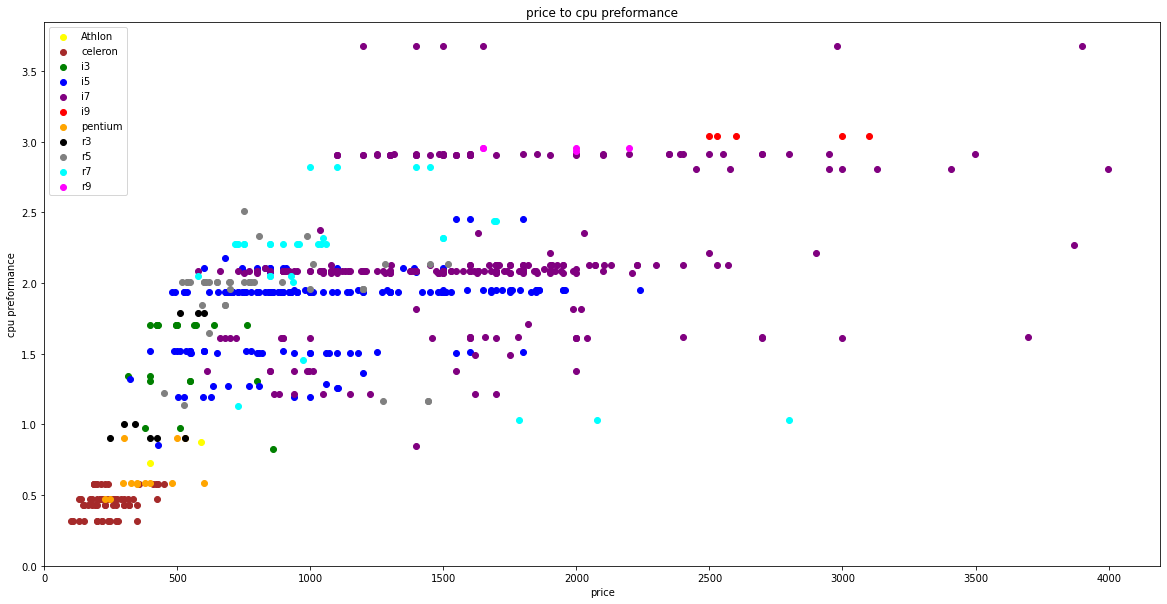

In [7]:
#scatter plot grouped by the cpu series
cpuBySeries = bestbuy.groupby("cpuSeries")
for series, group in cpuBySeries:
  plt.scatter(group.price, group.cpuPref, label=series, c=labelColors[series])
#graph labels
plt.xlabel("price")
plt.ylabel("cpu preformance")
plt.title(f"price to cpu preformance")
plt.ylim(0)
plt.xlim(0)
plt.legend(loc="upper left")
plt.show()

As the points moves towards the top left corner, the better price to performance a laptop is. Generally, performance increase as the series number increase and so does the price, i3/r3 < i5/r5 < i7/r7. The reason why some cpus in the same series perform worse is due to their generation (newer cpu = faster)

In [8]:
print(bestbuy.loc[bestbuy.cpuPref.idxmax()][["cpu", "cpuPref"]])
print(bestbuy.loc[bestbuy[bestbuy.cpuSeries == "i9"].cpu.index[0]][["cpu", "cpuPref"]])
print(bestbuy.loc[bestbuy[bestbuy.cpuSeries == "i7"].cpu.index[0]][["cpu", "cpuPref"]])

cpu        Intel 12th Generation Core i7 Evo Platform
cpuPref                                      3.677053
Name: 241, dtype: object
cpu        Intel 11th Generation Core i9
cpuPref                         3.042126
Name: 212, dtype: object
cpu        Intel 11th Generation Core i7
cpuPref                          2.08834
Name: 22, dtype: object


The best performing cpu is 12th gen, betting the i9 11th gen. However, the i9 11th gen beats the same generation i7 11th gen. 

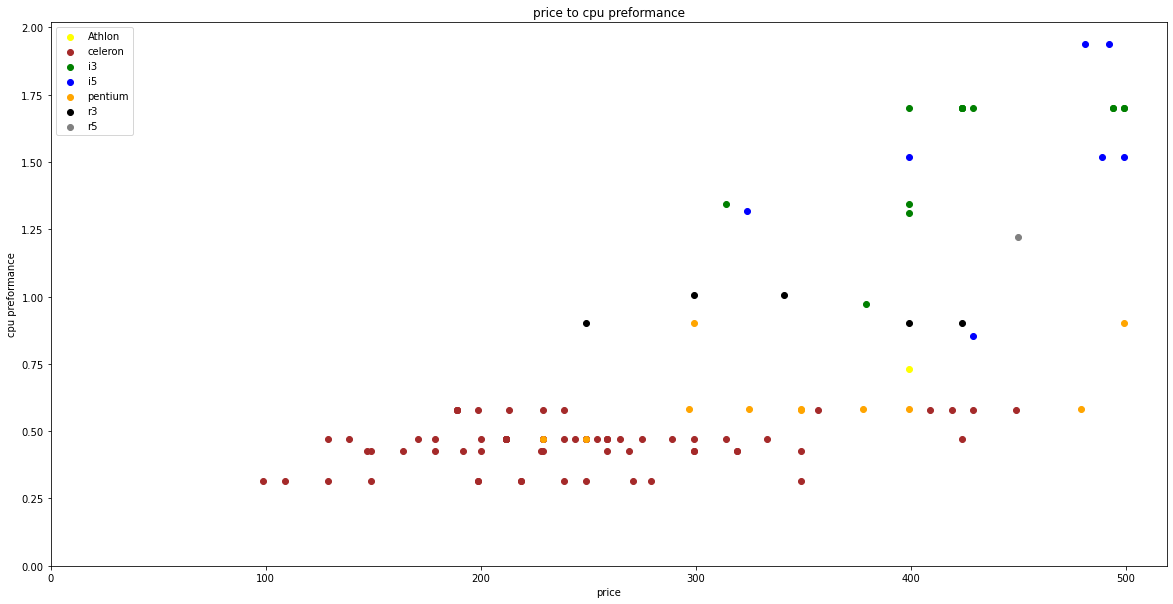

In [9]:
#focus on sub $500 laptops
cpuBySeries = bestbuy[bestbuy.price < 500].groupby("cpuSeries")
for series, group in cpuBySeries:
  plt.scatter(group.price, group.cpuPref, label=series, c=labelColors[series])
#graph labels
plt.xlabel("price")
plt.ylabel("cpu preformance")
plt.title(f"price to cpu preformance")
plt.ylim(0)
plt.xlim(0)
plt.legend(loc="upper left")
plt.show()

Looking at the sub \\$500 laptops, all of the celeron and pentium series are here. They are not worth the price at \\$300 or above, since similarly priced i3, i5, r3, r5 have better preformance at \\$300-\\$500 price range. There is 1 sub $300 r3 laptop.

In [10]:
bestbuy.loc[bestbuy[bestbuy.cpuSeries == "r3"].price.idxmin()]

price                               249
msrp                             429.99
cpu             AMD Ryzen 3 3000 Series
cpuNum                            3250U
ram                                   8
storage                             128
gpu                          AMD Radeon
screnSize                     14 inches
Resolution              1366 x 768 (HD)
os            Windows 11 Home in S Mode
brand                                HP
name                        14-fq0033dx
weight                             3.24
rating                              5.0
ratingLen                           2.0
cpuSeries                            r3
cpuPref                        0.902505
Name: 544, dtype: object

There are some flaws with this laptop like 128GB of storage, windows s mode, and being 2 generations old. But it beats celerons and pentiums. So if budget is a concern, it is possible to wait for a deal like this one instead of buying a celeron.

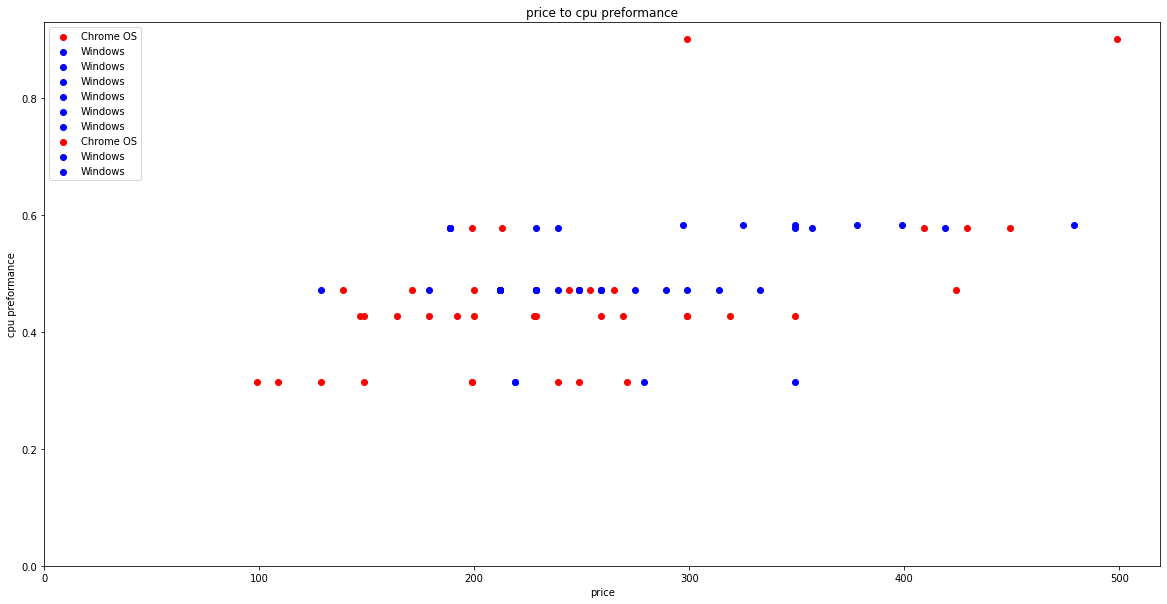

In [11]:
#focus on the OS of 
celeron = cpuBySeries.get_group("celeron")
for os, group in celeron.groupby("os"):
  if os == "Chrome OS":
    plt.scatter(group.price, group.cpuPref, label=os, c="red")
  else:
    plt.scatter(group.price, group.cpuPref, label="Windows", c="blue")
celeron = cpuBySeries.get_group("pentium")
for os, group in celeron.groupby("os"):
  if os == "Chrome OS":
    plt.scatter(group.price, group.cpuPref, label=os, c="red")
  else:
    plt.scatter(group.price, group.cpuPref, label="Windows", c="blue")
plt.xlabel("price")
plt.ylabel("cpu preformance")
plt.title(f"price to cpu preformance")
plt.ylim(0)
plt.xlim(0)
plt.legend(loc="upper left")
plt.show()

Around half of the OS is Chrome OS which indicates celeron and pentium are targeting low performance devices.

## GPU preformance
GPU preformance differs to CPU in terms of their workload. CPU is for general computation like running the OS and various programs. GPU focuses on graphics and speicalized workloads that work well with parallel processing. From a general consumer point of view, the GPU determines how well a game runs on a computer, with faster GPU equaling more FPS.

# Data Management  for GPU

In [12]:
#same as creating labels for cpu series
gpuSeries = (
  r"Intel (hd) Graphics [^Xe]", r"Intel.*(xe) Graphics", r"Intel (UHD Graphics \d+)"
  r"NVIDIA GeForce (MX\d{3})",
  r"NVIDIA (GeForce [GR]TX \d{3,4}M?(( Super)|( Ti)|( Max-Q))*)",
  r"NVIDIA (Quadro ([GR]TX)? [a-z]?\d{3,4}[a-z]?( Max-Q)?)",
  r"(NVIDIA RTX A\d000)",
  r"(Vega \d{1,2})"
)
def createSeries(df, labels):
  name = "gpuSeries"
  df[name] = np.nan

  for label in labels:
    match = df.gpu.str.extract(rf".*{label}.*", flags=re.I, expand=False)
    if isinstance(match, pd.DataFrame):
      match = match[0]
    boolList = (match.isnull() == False)
    df.loc[boolList, name] = match[boolList]
createSeries(bestbuy, gpuSeries)
createSeries(gpuBenchmark, gpuSeries)

In [13]:
print(set(bestbuy.loc[bestbuy.gpu.str.match(r".*(Vega \d{1,2}).*", flags=re.I) == True].cpu))

{'AMD Ryzen 7 Microsoft Surface Edition', 'AMD Ryzen 7 3000 Series', 'AMD Ryzen 3 3000 Series', 'AMD Ryzen 5 Microsoft Surface Edition', 'AMD Ryzen 5 3000 Series'}


There are only 3000 series and microsoft edition that are labelled with Vega graphics by bestbuy's API. AMD Vega pref changes between cpu generations thus only 3000 series vega are used since that is the only generation known.

In [14]:
gpuBenchmark.loc[gpuBenchmark.gpu.str.match(r".*Vega \d{1,2}.*Ryzen [45]000.*") == True, "gpuSeries"] = np.nan

In [15]:
#same formula as cpu
createPrefIdx(gpuBenchmark)
#add gpu and overall(cpu + gpu) preformance
def linkPref(bestbuy, gpuBenchmark):
  name = "gpuPref"
  name2 = "pref"
  bestbuy[name] = np.nan
  bestbuy[name2] = bestbuy.cpuPref
  gpuFound = gpuBenchmark.loc[
    gpuBenchmark.gpuSeries.isin(
      bestbuy[bestbuy.gpuSeries.isnull() == False].gpuSeries
    )
  ]
  for i, gpu in gpuFound.iterrows():
    boolList = (bestbuy.gpuSeries == gpu.gpuSeries)
    bestbuy.loc[boolList, name] = gpu.pref
    bestbuy.loc[boolList, name2] += gpu.pref
linkPref(bestbuy, gpuBenchmark)

There is a lack of benchmarks for intels HD igpus. Their performance is only good enough to run general browsering like youtube videos. The underpower graphics and age of the product results in a lack of benchmarks for HD igpus.

In [16]:
for series in ("Xe", "HD"):
  bestbuyHD = set(bestbuy[bestbuy.gpuSeries == series].gpu)
  gpuBenchmarkHD = set(gpuBenchmark[gpuBenchmark.gpuSeries == series].gpu)

  for gpu in bestbuyHD:
    if gpu not in gpuBenchmarkHD:
      print(gpu)

Intel Iris Xe Graphics
Intel HD Graphics 4400
Intel HD Graphics 5000
Intel HD Graphics 5500


These are the missing igpu skus that can't be found in the gpu benchmarks.

In [17]:
print(set(bestbuy[bestbuy.gpuSeries == "Xe"].gpu))
print(gpuBenchmark[gpuBenchmark.gpuSeries == "Xe"][["gpu", "pref"]])

{'Intel Iris Xe Graphics'}
                                 gpu      pref
94   Intel Iris Xe Graphics G7 96EUs  0.273859
109  Intel Iris Xe Graphics G7 80EUs  0.190991


Intel's Xe graphics are poorly labelled by their execution units (EUs). The average of these 2 benchmark is used to approximate a cpu with "Intel Iris Xe Graphics".

In [18]:
#get all gpu benhcmarks for Xe and HD, then averaging their pref
gpuBySeries = gpuBenchmark.groupby("gpuSeries")
for series in ("Xe", "HD"):
  group = gpuBySeries.get_group(series)
  gpuBenchmark.loc[group.index, "pref"] = group.pref.mean()

# visualization with analysis

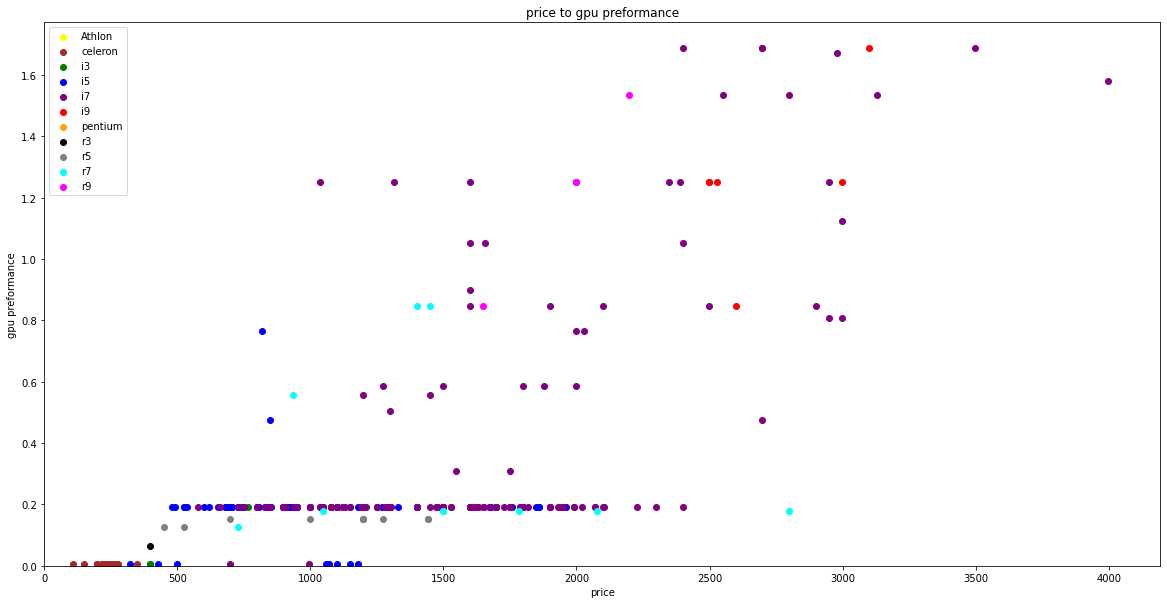

In [20]:
for series, group in cpuBySeries:
  plt.scatter(group.price, group.gpuPref, label=series, c=labelColors[series])
#graph labels
plt.xlabel("price")
plt.ylabel("gpu preformance")
plt.title(f"price to gpu preformance")
plt.ylim(0)
plt.xlim(0)
plt.legend(loc="upper left")
plt.show()

For most \\$1000 or more laptops, most of the cost is in the gpu as there is a huge increase in GPU preformance for most of them.

In [28]:
print(bestbuy.loc[bestbuy.price.idxmax()][["price","cpuNum","gpuSeries","pref"]])
print(bestbuy.loc[bestbuy.gpuPref.idxmax()][["price","cpuNum","gpuSeries","pref"]])

price                    3999
cpuNum                 11850H
gpuSeries    NVIDIA RTX A4000
pref                 4.385154
Name: 354, dtype: object
price                    2399
cpuNum                 11800H
gpuSeries    GeForce RTX 3080
pref                 4.597748
Name: 29, dtype: object


The \\$4000 laptop preformed worse than the \\$2400 is due to the different workload a RTX A4000 is designed for. A4000 can be used for gaming; athough it was desgined for professional work loads like Blender. The benchmarks used for GPU were for gaming and not representitve of A4000 actually value.

A polynomial regression will be used to predict the overall performance of a laptop based on price since prices increases faster than preformance does. This is because customers spending \\$1k or more on their laptop have more disposable income and thus are willing to pay more.

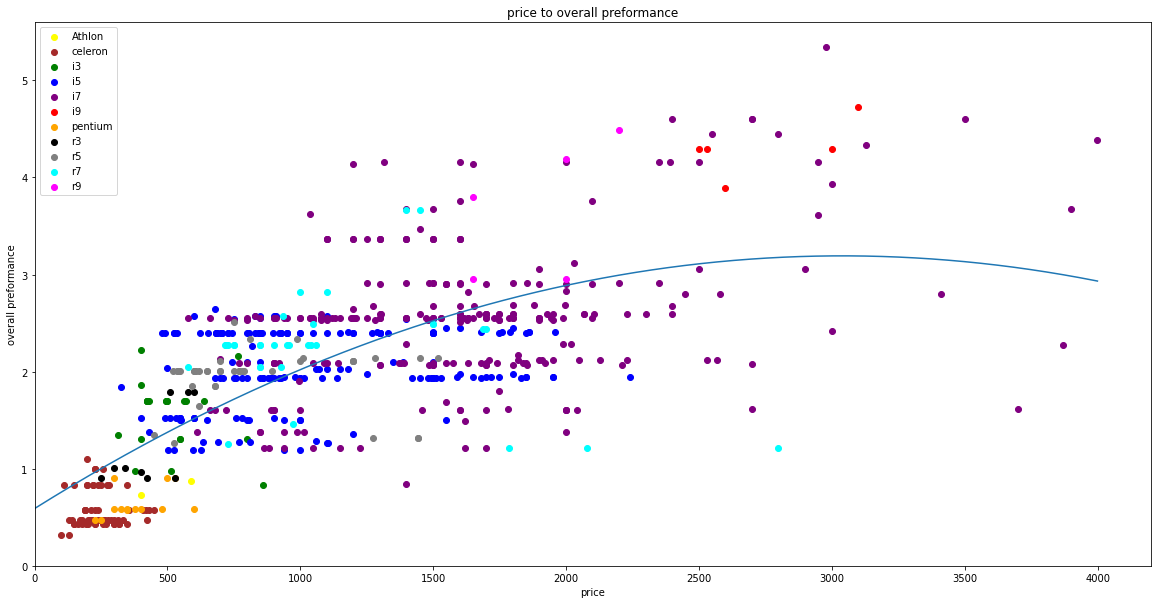

In [66]:
#transforming inputs and outputs into a polynomial inputs and ouputs of degree 2
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_x = poly.fit_transform(np.array(bestbuy.price).reshape(-1,1))
poly_y = poly.fit_transform(np.array(bestbuy.pref).reshape(-1,1))

linReg2 = LinearRegression()
linReg2.fit(poly_x, poly_y)

for series, group in cpuBySeries:
  plt.scatter(group.price, group.pref, label=series, c=labelColors[series])

plt.plot(pricepoints, linReg2.predict(poly.fit_transform(pricepoints))[:,0])
#graph labels
plt.xlabel("price")
plt.ylabel("overall preformance")
plt.title(f"price to overall preformance")
plt.ylim(0)
plt.xlim(0)
plt.legend(loc="upper left")
plt.show()

# linReg = LinearRegression()
# linReg.fit(np.array(bestbuy.price).reshape(-1,1), bestbuy.pref)
# pricepoints = np.linspace(0, bestbuy.price.max(), len(bestbuy)).reshape(-1,1)

# for series, group in cpuBySeries:
#   plt.scatter(group.price, group.pref, label=series, c=labelColors[series])

# plt.plot(pricepoints, linReg.predict(pricepoints))
# #graph labels
# plt.xlabel("price")
# plt.ylabel("overall preformance")
# plt.title(f"price to overall preformance")
# plt.ylim(0)
# plt.xlim(0)
# plt.legend(loc="upper left")
# plt.show()

The preformance decreases around \\$3000 because of the previously mention professional GPU (RTX A4000) are not designed for gaming.

## hypothesis testing

In [65]:
# x2 = sm.add_constant(poly.fit_transform(pricepoints))
mod = sm.OLS(bestbuy.price, poly_x).fit()
print(mod.summary())

# x2 = sm.add_constant(pricepoints)
# mod = sm.OLS(bestbuy.pref, x2)
# fii = mod.fit()
# p_values = fii.summary2().tables[1]['P>|t|']
# # print(p_values)
# print(fii.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.348e+34
Date:                Mon, 16 May 2022   Prob (F-statistic):                        0.00
Time:                        15:01:46   Log-Likelihood:                          17974.
No. Observations:                 647   AIC:                                 -3.594e+04
Df Residuals:                     645   BIC:                                 -3.594e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

F-statistic is greater than 0 and Prob (F-statistic) equals 0, which means price is related to the performance. The p-value for both variable is 0, thus the null hypothesis of no relation is reject. It is concerning R^2 equals 1 when the regression clearly doesn't fit all the data points. Not sure why statsmodels reported that value.

# insights and conclusions
Laptops have large variantions of features. Just analyzing the performance of a laptop shows there is a large variation in performance at a price point. The figure with the polynomial regression can eliminate poor performing laptops. If the performance of a laptop is under the line, the laptop is below average in terms of performance and shouldn't be bought. If the laptop's performance is above the regression it's still difficult to determine if it's worth buying as there is other factors (such as weight) that are not included.